In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.extend(['.', '..'])

import numpy as np
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex='True')
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Wedge
from matplotlib.legend_handler import HandlerPatch
plt.style.use('./paper.mplstyle')

mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
    r'\usepackage{accents}',
    r'\DeclareSymbolFont{matha}{OML}{txmi}{m}{it}',
    r'\DeclareMathSymbol{\nu}{\mathord}{matha}{118}']
mpl.rcParams['text.latex.unicode'] = True

import ternary

from utils import fr as fr_utils
from utils import misc as misc_utils
from utils import plot as plot_utils
from utils.enums import Texture

../utils/plot.py:24: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shivesh/programs/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/shivesh/programs/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499,

In [3]:
tRed = np.array([226,101,95]) / 255.
tBlue = np.array([96,149,201]) / 255.
tGreen = np.array([170,196,109]) / 255.

In [4]:
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        r = 10
        x = r + width//2 + 10
        y = height//2 - 3

        # create 
        p = Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

In [5]:
s = [1, 2, 0]
SM_120 = [fr_utils.normalise_fr(s), fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))]
s = [0, 1, 0]
SM_010 = [fr_utils.normalise_fr(s), fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))]
s = [1, 0, 0]
SM_100 = [fr_utils.normalise_fr(s), fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))]
print SM_120
print SM_010
print SM_100

SM_X = np.load('./chains/mc_x.npy')

[array([0.33333333, 0.66666667, 0.        ]), array([0.30535346, 0.3527747 , 0.34187184])]
[array([0., 1., 0.]), array([0.18301213, 0.43765598, 0.37933189])]
[array([1., 0., 0.]), array([0.55003613, 0.18301213, 0.26695174])]


In [6]:
nbins = 25
fontsize = 23

../utils/plot.py:258: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a*b*c/(4.0*area)
/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


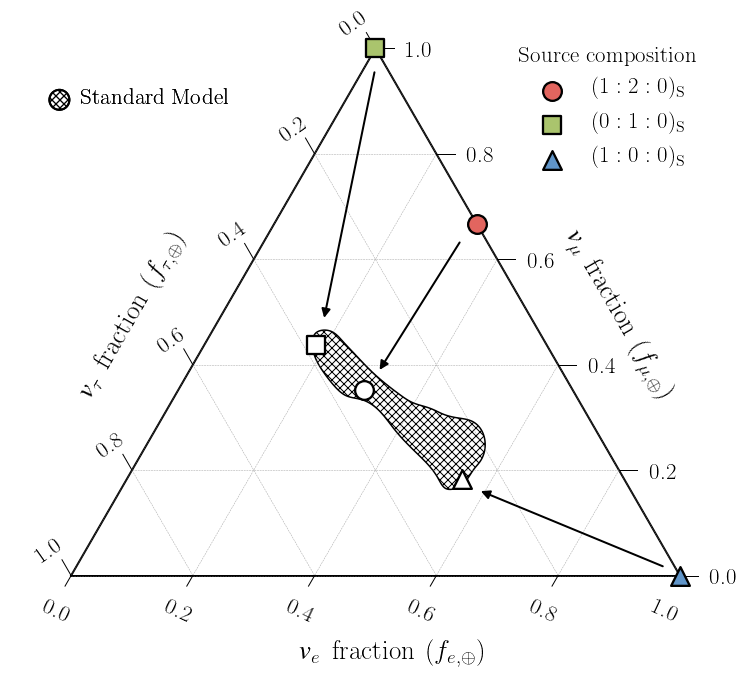

In [7]:
# Figure
fig = plt.figure(figsize=(12, 12))

# Axis
ax = fig.add_subplot(111)
#ax_labels = [r'$f_{e,\oplus}$', r'$f_{\mu,\oplus}$', r'$f_{\tau,\oplus}$']
ax_labels = [r'$\nu_e\:\:{\rm fraction}\:\left( f_{e,\oplus}\right)$',
             r'$\nu_\mu\:\:{\rm fraction}\:\left( f_{\mu,\oplus}\right)$',
             r'$\nu_\tau\:\:{\rm fraction}\:\left( f_{\tau,\oplus}\right)$']
tax = plot_utils.get_tax(ax, scale=nbins, ax_labels=ax_labels, rot_ax_labels=True)

# Plot
tax.scatter([SM_120[0]*nbins], marker='o', s=350, facecolors=tRed,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(1:2:0\smash{)_{\rm S}}$')
tax.scatter([SM_010[0]*nbins], marker='s', s=350, facecolors=tGreen,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(0:1:0\smash{)_{\rm S}}$')
tax.scatter([SM_100[0]*nbins], marker='^', s=350, facecolors=tBlue,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(1:0:0\smash{)_{\rm S}}$')

tax.scatter([SM_120[1]*nbins], marker='o', s=350, edgecolors='k',
            facecolors='white', linewidth=2.3, zorder=10)
tax.scatter([SM_010[1]*nbins], marker='s', s=350, edgecolors='k',
            facecolors='white', linewidth=2.3, zorder=10)
tax.scatter([SM_100[1]*nbins], marker='^', s=350, edgecolors='k',
            facecolors='white', linewidth=2.3, zorder=10)

ax.annotate("", xy=np.array([0.415, 0.42])*nbins, xytext=np.array([0.499, 0.83])*nbins,
            arrowprops=dict(arrowstyle="-|>",facecolor='k',lw=2))
ax.annotate("", xy=np.array([0.505, 0.335])*nbins, xytext=np.array([0.64, 0.55])*nbins,
            arrowprops=dict(arrowstyle="-|>",facecolor='k',lw=2))
ax.annotate("", xy=np.array([0.67, 0.14])*nbins, xytext=np.array([0.975, 0.014])*nbins,
            arrowprops=dict(arrowstyle="-|>",facecolor='k',lw=2))

# Legend
l_size = fontsize
legend = plt.legend(loc=(0.7, 0.75), title=r'Source composition',
                    fontsize=l_size, prop={'size': fontsize})
plt.setp(legend.get_title(), fontsize=l_size)
ax.add_artist(legend)

plot_utils.flavour_contour(
    frs = SM_X,
    ax = ax,
    fill = True,
    nbins = nbins,
    coverage = 90,
    linewidth = 1.5,
    edgecolor = 'k',
    facecolor = 'none',
    alpha = 1,
    zorder = 2,
    oversample = 10,
    delaunay = True,
    d_alpha = 0.1,
    smoothing = 4,
    hatch = 'XXX'
)

legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='none', hatch='XXX', edgecolor='k',
           linewidth=2., label=r'Standard Model')
)
legend = plt.legend(handles=legend_elements, loc=(-0.05, 0.85),
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')
ax.add_artist(legend)

fig.savefig('./plots/thesis.pdf', bbox_inches='tight', dpi=150)